In [17]:
import sys
from pathlib import Path
import os
from torch.utils.data import DataLoader
import torch

In [18]:
from IPython.display import clear_output
!pip install -q ultralytics tryalgo fiftyone
clear_output()

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
from tryalgo.union_rectangles import union_rectangles_fastest
from PIL import Image

def intersect_segments(x1, x2, x3, x4):
    """
    Calculate the intersection of two line segments [x1, x2] and [x3, x4].
    Return the intersection coordinates if they exist, otherwise None.
    """
    assert x1 <= x2 and x3 <= x4
    if x1 >= x3:
        x1, x3 = x3, x1
        x2, x4 = x4, x2
    if x2 >= x3:
        return (x3, x2)
    return None


def intersect_bboxes(bbox1, bbox2):
    """
    Calculate the intersection of two rectangular bounding boxes.
    Return the intersection coordinates if they exist, otherwise None.
    """
    x1, y1, x2, y2 = bbox1
    x3, y3, x4, y4 = bbox2
    x_intersection = intersect_segments(x1, x2, x3, x4)
    y_intersection = intersect_segments(y1, y2, y3, y4)
    if x_intersection == None or y_intersection == None:
        return None
    return (x_intersection[0], y_intersection[0], x_intersection[1], y_intersection[1])
    

def intersect_many_bboxes(bboxes1, bboxes2):
    """
    Find all intersections between two sets of rectangular bounding boxes.
    This intersections may overlap!
    Return a list of intersection coordinates.
    """
    result = []
    for i, bbox1 in enumerate(bboxes1):
        for bbox2 in bboxes2[i:]:
            curr_bbox = intersect_bboxes(bbox1, bbox2)
            if curr_bbox != None:
                result.append(curr_bbox)
    return result


def get_bboxes(model, img):
    """
    Extract bounding boxes from the model's prediction on the given image.
    Resize the image to 640x640 pixels before processing.
    """
    img = img.convert('RGB')
    img = img.resize((640, 640)).to(device)
    
    outputs = model(img)
    bboxes = []
    for output in outputs:
        bboxes.extend(list(output.boxes.xyxy.detach().numpy()))
    return bboxes


def calculate_iou_diff_models(img, model1, model2):
    """
    Calculate the Intersection over Union (IoU) difference between two models
    on the same image. This metric compares overlapping areas between predictions.
    """
    bboxes1 = get_bboxes(model1, img)
    bboxes2 = get_bboxes(model2, img)
    
    intersected_bboxes = intersect_many_bboxes(bboxes1, bboxes2)
    return union_rectangles_fastest(intersected_bboxes) / union_rectangles_fastest(bboxes1 + bboxes2)


def calculate_iou_diff_images(img1, img2, model):
    """
    Calculate the Intersection over Union (IoU) difference between two images
    processed by the same model. This metric compares overlapping areas
    between predictions on different input images.
    """
    bboxes1 = get_bboxes(model, img1)
    bboxes2 = get_bboxes(model, img2)
    
    intersected_bboxes = intersect_many_bboxes(bboxes1, bboxes2)
    return union_rectangles_fastest(intersected_bboxes) / union_rectangles_fastest(bboxes1 + bboxes2)


def get_bboxes_batch(model, imgs):
    """
    Extract bounding boxes from the model's predictions on a batch of images.
    The model should handle batch processing. Returns a list of bounding boxes 
    for each image in the batch.
    """
    assert isinstance(imgs, list)
    if all(isinstance(img, str) for img in imgs):
        imgs = [Image.open(img).convert('RGB').resize((640, 640)) for img in imgs]
    else:
        imgs = [img.convert('RGB').resize((640, 640)) for img in imgs]
    imgs = imgs
    outputs = model(imgs, verbose=False)
    
    bboxes_batch = []
    for output in outputs:
        bboxes = list(output.boxes.xyxy.detach().cpu().numpy())
        bboxes_batch.append(bboxes)
    
    return bboxes_batch


def intersect_many_bboxes_batch(bboxes_batch1, bboxes_batch2):
    """
    Find all intersections between two batches of bounding boxes.
    Returns a list of intersection bounding boxes for each corresponding pair
    of bounding box batches.
    """
    result_batch = []
    for bboxes1, bboxes2 in zip(bboxes_batch1, bboxes_batch2):
        result = intersect_many_bboxes(bboxes1, bboxes2)
        result_batch.append(result)
    
    return result_batch


def calculate_iou_diff_models_batch(imgs, model1, model2):
    """
    Calculate the IoU difference between two models over a batch of images.
    This metric compares overlapping areas between predictions.
    """
    bboxes_batch1 = get_bboxes_batch(model1, imgs)
    bboxes_batch2 = get_bboxes_batch(model2, imgs)
    
    intersected_bboxes_batch = intersect_many_bboxes_batch(bboxes_batch1, bboxes_batch2)
    
    iou_diffs = []
    for intersected_bboxes, bboxes1, bboxes2 in zip(intersected_bboxes_batch, bboxes_batch1, bboxes_batch2):
        union_area = union_rectangles_fastest(bboxes1 + bboxes2)
        intersect_area = union_rectangles_fastest(intersected_bboxes)
        iou_diff = float(min(intersect_area / union_area, 1.0)) if union_area > 1e-3 else 1.0
        iou_diffs.append(iou_diff)
    
    return iou_diffs


def calculate_iou_diff_images_batch(imgs1, imgs2, model):
    """
    Calculate the IoU difference between two batches of images processed by the same model.
    This metric compares overlapping areas between predictions on different input images.
    """
    bboxes_batch1 = get_bboxes_batch(model, imgs1)
    bboxes_batch2 = get_bboxes_batch(model, imgs2)
    
    intersected_bboxes_batch = intersect_many_bboxes_batch(bboxes_batch1, bboxes_batch2)
    
    iou_diffs = []
    for intersected_bboxes, bboxes1, bboxes2 in zip(intersected_bboxes_batch, bboxes_batch1, bboxes_batch2):
        union_area = union_rectangles_fastest(bboxes1 + bboxes2)
        intersect_area = union_rectangles_fastest(intersected_bboxes)
        iou_diff = float(intersect_area / union_area)
        iou_diffs.append(iou_diff)
    
    return iou_diffs

In [21]:
import torch
from ultralytics import YOLO
from tryalgo.union_rectangles import union_rectangles_fastest
from PIL import Image
import numpy as np

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def calculate_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    true_positive = 0
    false_positive = 0
    false_negative = len(gt_boxes)
    
    for pred_box in pred_boxes:
        matched = False
        for gt_box in gt_boxes:
            iou = calculate_iou(pred_box[:4], gt_box[:4])
            if iou >= iou_threshold:
                true_positive += 1
                false_negative -= 1
                matched = True
                break
        if not matched:
            false_positive += 1

    precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
    recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    return precision, recall

def calculate_mean_iou(bboxes1, bboxes2, wrong_label_penalty=0.5, iou_threshold=0.5):
    iou_scores = []
    for box1 in bboxes1:
        for box2 in bboxes2:
            iou = calculate_iou(box1[:4], box2[:4])
            if iou > iou_threshold:  # Сравниваем только после прохождения порога
                # Если метка класса не совпадает, то не беда -- оштрафуем немножко и добавим.
                iou_scores.append(iou if box1[5] == box2[5] else wrong_label_penalty * iou)

    mean_iou = float(np.mean(iou_scores)) if iou_scores else 0.0
    return mean_iou

def get_stat_bboxes_batch(imgs, model):    
    results = model(imgs, verbose=False)
    ret = []
    for result in results:
        pred_boxes = []
        for box, conf, cls in zip(
            result.boxes.xyxy.cpu().numpy(),
            result.boxes.conf.cpu().numpy(),
            result.boxes.cls.cpu().numpy()
        ):
            x1, y1, x2, y2 = box
            pred_boxes.append([int(x1), int(y1), int(x2), int(y2), float(conf), int(cls)])
        ret.append(pred_boxes)
    return ret


def calculate_stat_models_batch(imgs, model1, model2, wrong_label_penalty=0.2, iou_threshold=0.2, max_length=10, padding_value=0):
    def pad_or_truncate(lst, length, padding_value):
        """Ensure a list is of the specified length by truncating or padding with a placeholder."""
        return (lst[:length] + [padding_value] * max(0, length - len(lst)))

    stats = []
    results1 = get_stat_bboxes_batch(imgs, model1)
    results2 = get_stat_bboxes_batch(imgs, model2)

    for pred_boxes1, pred_boxes2 in zip(results1, results2):
        mean_iou = calculate_mean_iou(pred_boxes1, pred_boxes2, wrong_label_penalty, iou_threshold)
        precision, recall = calculate_precision_recall(pred_boxes1, pred_boxes2)
                
        to_append = [mean_iou, precision, recall]
        stats.append(to_append)
    
    return stats


def calculate_stat_model_batch(imgs, model):
    stats = []
    results = get_stat_bboxes_batch(imgs, model)

    for pred_boxes in results:
        # print(pred_boxes)
        if pred_boxes == []:
            stats.append([0, 0, 0, 0, 0])
            continue
        num_pred = len(pred_boxes)
        num_unique = len(np.unique([item[4] for item in pred_boxes]))
        avg_conf = np.mean([item[4] for item in pred_boxes])

        area = union_rectangles_fastest([item[:4] for item in pred_boxes])

        center = np.mean([item[:4] for item in pred_boxes])

        to_append = [avg_conf, num_pred, num_unique / num_pred, area, center]
        stats.append(to_append)
    
    return stats

In [36]:
import os
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import DataLoader, Dataset
import fiftyone.zoo as foz
from ctypes import c_double
import json
import torch
import torch.nn as nn

class DatasetOfPaths(Dataset):
    def __init__(self, filepaths):
        self.filepaths = filepaths

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        return self.filepaths[idx]


class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(Classifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

        self.bn1 = nn.BatchNorm1d(hidden_dim1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)

        out = self.fc3(out)
        out = self.sigmoid(out)
        return out


class EnsembleOfCheckpoints:
    def __init__(self, n_checkpoints=20, step=5, start=0, folder_path=".\\checkpoints", prefix="epoch", yolo_model="yolo11n.pt", v2 = True):
        self.n_checkpoints = n_checkpoints
        self.step = step
        self.folder_path = folder_path
        self.prefix = prefix
        self.start = start
        self.checkpoints = self.load_checkpoints()
        self.weights = self.get_weights(len(self.checkpoints) - 1)
        self.thresh = 0.5
        self.yolo_model = yolo_model
        self.yolo = YOLO(yolo_model)
        self.v2 = v2
        
    def save(self, path):
        """
        Saves the ensemble to a specified path, including YOLO model paths, 
        classifier weights, and ensemble metadata.
        """
        data_to_save = {
            "classifier_state_dict": self.classifier.state_dict(),
            "weights": self.weights.tolist(),
            "thresh": self.thresh,
            "n_checkpoints": self.n_checkpoints,
            "step": self.step,
            "start": self.start,
            "folder_path": self.folder_path,
            "prefix": self.prefix,
            "yolo_model": self.yolo_model,
            "v2": self.v2
        }

        # Save the data to a file
        save_file = path if path.endswith(".pth") else f"{path}.pth"
        torch.save(data_to_save, save_file)

    @classmethod
    def load(cls, path):
        """
        Loads the ensemble from a saved file.
        """
        save_file = path if path.endswith(".pth") else f"{path}.pth"
        saved_data = torch.load(save_file)

        ensemble = cls(
            n_checkpoints=saved_data["n_checkpoints"],
            step=saved_data["step"],
            start=saved_data["start"],
            folder_path=saved_data["folder_path"],
            prefix=saved_data["prefix"],
            v2=saved_data["v2"]
        )
        ensemble.classifier = Classifier(12 * (saved_data["n_checkpoints"] - 1), 64, 128) if saved_data["v2"] else Classifier((saved_data["n_checkpoints"] - 1), 64, 128)
        ensemble.classifier.load_state_dict(saved_data["classifier_state_dict"])

        ensemble.yolo_model = saved_data["yolo_model"]
        ensemble.yolo = YOLO(saved_data["yolo_model"])

        ensemble.weights = np.array(saved_data["weights"])
        ensemble.thresh = saved_data["thresh"]

        return ensemble

    def _compute_metrics(self, y_true, y_pred):
        """
        Private method to compute precision, recall, and F1 score.
        """
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        return precision, recall, f1

    def voting(self, dataloader):
        """
        Perform voting with divergence computation between checkpoints and last checkpoint.
        """
        num_checkpoints = len(self.checkpoints)
        num_images = len(dataloader.dataset)
        
        divergences = np.zeros((num_checkpoints - 1, num_images))
        last_checkpoint = self.checkpoints[-1]
        
        for i in range(num_checkpoints - 1):
            checkpoint = self.checkpoints[i]
            
            for j, batch in enumerate(dataloader):
                iou = calculate_iou_diff_models_batch(batch, last_checkpoint, checkpoint)
                divergences[i, j * len(batch):j * len(batch) + len(batch)] = iou
        
        return divergences.T

    def voting_new(self, dataloader):
        num_checkpoints = len(self.checkpoints)
        num_images = len(dataloader.dataset)
        
        divergences = [[None for _ in range(num_images)] for _ in range(num_checkpoints - 1)]
        last_checkpoint = self.checkpoints[-1]
        
        for i in range(num_checkpoints - 1):
            checkpoint = self.checkpoints[i]
            checkpoint_next = self.checkpoints[i + 1]
            st = 0
            for j, batch in enumerate(dataloader):
                div_stat = calculate_stat_models_batch(batch, last_checkpoint, checkpoint)
                div_stat_next = calculate_stat_models_batch(batch, checkpoint_next, checkpoint)
                stat_checkpoint = calculate_stat_model_batch(batch, checkpoint)
                iou = calculate_iou_diff_models_batch(batch, last_checkpoint, checkpoint)
                for k in range(len(div_stat)):
                    div_stat[k].append(iou[k])
                    div_stat[k].extend(div_stat_next[k])
                    div_stat[k].extend(stat_checkpoint[k])
                divergences[i][st:st + len(batch)] = div_stat
                st += len(batch)
        divergences = np.array(divergences).transpose(1, 0, 2)
        shape = divergences.shape
        new_shape = shape[:-2] + (shape[-2] * shape[-1],)
        divergences = divergences.reshape(new_shape)
        return divergences

    def train(self, data_pos, data_neg, plot=False, split_size=0.9, epochs=500):
        """
        Public method to train the model, save the best model based on validation loss,
        and optionally plot training and validation metrics.
        """
        if not (0.0 < split_size < 1.0):
            raise ValueError("split_size must be a float between 0 and 1 (exclusive).")
        
        print("Starting calculation of divergences between non-noisy images")
        pos_divergences = self.voting_new(data_pos) if self.v2 else self.voting(data_pos)
        print("Starting calculating of divergences between noisy images")
        neg_divergences = self.voting_new(data_pos) if self.v2 else self.voting(data_neg)
    
        n_pos = pos_divergences.shape[0]
        n_neg = neg_divergences.shape[0]
        print(pos_divergences.shape)
        X = np.vstack([
            pos_divergences, 
            neg_divergences
        ])
        y = [1] * n_pos + [0] * n_neg
        
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=(1 - split_size), random_state=42, stratify=y
        )
        
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val)
        
        print("Starting model training: ")
        self.classifier = Classifier(X_train.shape[1], 64, 128)
        optimizer = torch.optim.AdamW(self.classifier.parameters(), lr=0.01)
        loss_fn = torch.nn.BCELoss()
        
        best_val_loss = float('inf')
        best_model_state = None
        
        train_loss_history = []
        val_loss_history = []
        train_accuracy_history = []
        val_accuracy_history = []
        precision_history = []
        recall_history = []
        f1_history = []
        print(X_train_tensor.shape)
        
        for epoch in range(epochs):
            # Training step
            self.classifier.train()
            optimizer.zero_grad()
            
            outputs = self.classifier(X_train_tensor)
            train_loss = loss_fn(outputs, y_train_tensor.view(-1, 1))
            train_loss.backward()
            optimizer.step()
            
            # Calculate training metrics
            with torch.no_grad():
                train_preds = (outputs > self.thresh).float()
                train_labels = y_train_tensor.view(-1, 1).float()
                train_acc = (train_preds == train_labels).sum().item() / len(y_train_tensor)
                
                train_preds_np = train_preds.cpu().numpy()
                train_labels_np = train_labels.cpu().numpy()
                
                train_precision, train_recall, train_f1 = self._compute_metrics(train_labels_np, train_preds_np)
            
            # Validation step
            self.classifier.eval()
            with torch.no_grad():
                val_outputs = 1 - self.classifier(X_val_tensor)
                val_loss = loss_fn(val_outputs, y_val_tensor.view(-1, 1))
                
                val_preds = (val_outputs > self.thresh).float()
                val_labels = y_val_tensor.view(-1, 1).float()
                val_acc = (val_preds == val_labels).sum().item() / len(y_val_tensor)
                
            # Save the best model based on validation loss
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = self.classifier.state_dict()  # Save the best model state
            
            # Track statistics
            train_loss_history.append(train_loss.item())
            val_loss_history.append(val_loss.item())
            train_accuracy_history.append(train_acc)
            val_accuracy_history.append(val_acc)
            precision_history.append(train_precision)
            recall_history.append(train_recall)
            f1_history.append(train_f1)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch+1}, "
                      f"Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
                      f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, "
                      f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        
        # Update self.classifier with the best model
        if best_model_state:
            self.classifier.load_state_dict(best_model_state)
            print(f"Best model loaded with validation loss: {best_val_loss:.4f}")
        
        # Plot training and validation statistics
        if plot:
            plt.figure(figsize=(14, 10))
            
            # Plot loss
            plt.subplot(2, 2, 1)
            plt.plot(range(epochs), train_loss_history, label='Train Loss', color='blue')
            plt.plot(range(epochs), val_loss_history, label='Validation Loss', color='orange')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss over Epochs')
            plt.legend()
            
            # Plot accuracy
            plt.subplot(2, 2, 2)
            plt.plot(range(epochs), train_accuracy_history, label='Train Accuracy', color='green')
            plt.plot(range(epochs), val_accuracy_history, label='Validation Accuracy', color='red')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Accuracy over Epochs')
            plt.legend()
            
            # Plot precision
            plt.subplot(2, 2, 3)
            plt.plot(range(epochs), precision_history, label='Precision', color='purple')
            plt.xlabel('Epoch')
            plt.ylabel('Precision')
            plt.title('Precision over Epochs')
            plt.legend()
            
            # Plot recall
            plt.subplot(2, 2, 4)
            plt.plot(range(epochs), recall_history, label='Recall', color='brown')
            plt.xlabel('Epoch')
            plt.ylabel('Recall')
            plt.title('Recall over Epochs')
            plt.legend()
            
            # Adjust layout and save the figure
            plt.tight_layout()
            plt.savefig('training_validation_metrics.png')
            plt.show()
        
        return
    
    def get_weights(self, n, k = 0.5):
        """
        Generates weights for checkpoints such that their sum equals to 1, with a "smoothnest" parameter k.
        """
        w = np.array([(i / n)**k for i in range(1, n + 1)])
        return w / w.sum()

    def load_checkpoints(self):
        """
        Loads YOLO checkpoints based on initialized parameters.
        """
        loaded_checkpoints = []
        
        for i in range(self.start, self.start + self.n_checkpoints * self.step, self.step):
            checkpoint_name = f"{self.prefix}{i}.pt"
            checkpoint_path = os.path.join(self.folder_path, checkpoint_name)
            
            print(f"Loading checkpoint: {checkpoint_path}")
            loaded_checkpoints.append(YOLO(checkpoint_path).to(device))
        
        return loaded_checkpoints
    
    def vote_one_image(self, image_path):
        """
        Perform voting with divergence computation between checkpoints and last checkpoint FOR ONLY ONE IMAGE.
        """
        self.classifier.eval()
        dataloader = DataLoader(dataset=DatasetOfPaths([image_path]), batch_size=1, shuffle=False)
        
        divergences = self.voting_new(dataloader) if self.voting_new else self.voting(dataloader)
        
        div_tensor = torch.FloatTensor(divergences)
        pred = self.classifier(div_tensor)[0]
        pred = 1 - pred if self.v2 else pred
        return pred > self.thresh, pred, self.yolo(image_path)
    
def get_coco_dataloader(n_images=64, batch_size=64):
    coco_dataset = foz.load_zoo_dataset(
        "coco-2017",
        split="test",
        max_samples=int(n_images),
        shuffle=False,
    )

    pytorch_dataset = DatasetOfPaths([sample.filepath for sample in coco_dataset])

    coco_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=batch_size, shuffle=False)
    
    return coco_dataloader

In [23]:
# FOR KAGGLE ONLY

!mkdir -p /kaggle/working/yolo8_checkpoints
!cp /kaggle/input/yolo8-checkpoints/* /kaggle/working/yolo8_checkpoints/

In [24]:
# FOR KAGGLE ONLY

!mkdir -p /kaggle/working/yolo11_checkpoints
!cp /kaggle/input/adamw-yolo-checkpoints/* /kaggle/working/yolo11_checkpoints/

In [31]:
ensemble_yolo8 = EnsembleOfCheckpoints(folder_path='./yolo8_checkpoints', n_checkpoints=8, start=60, yolo_model="yolov8n.pt", v2=True)

Loading checkpoint: ./yolo8_checkpoints/epoch60.pt
Loading checkpoint: ./yolo8_checkpoints/epoch65.pt
Loading checkpoint: ./yolo8_checkpoints/epoch70.pt
Loading checkpoint: ./yolo8_checkpoints/epoch75.pt
Loading checkpoint: ./yolo8_checkpoints/epoch80.pt
Loading checkpoint: ./yolo8_checkpoints/epoch85.pt
Loading checkpoint: ./yolo8_checkpoints/epoch90.pt
Loading checkpoint: ./yolo8_checkpoints/epoch95.pt


In [26]:
ensemble_yolo11 = EnsembleOfCheckpoints(folder_path='./yolo11_checkpoints', n_checkpoints=8, start=60, yolo_model="yolo11n.pt", v2=True)

Loading checkpoint: ./yolo11_checkpoints/epoch60.pt
Loading checkpoint: ./yolo11_checkpoints/epoch65.pt
Loading checkpoint: ./yolo11_checkpoints/epoch70.pt
Loading checkpoint: ./yolo11_checkpoints/epoch75.pt
Loading checkpoint: ./yolo11_checkpoints/epoch80.pt
Loading checkpoint: ./yolo11_checkpoints/epoch85.pt
Loading checkpoint: ./yolo11_checkpoints/epoch90.pt
Loading checkpoint: ./yolo11_checkpoints/epoch95.pt


In [27]:
root_path = '/kaggle/input/500-test-images/coco-2017'
test_path = os.path.join(root_path, 'test/data/')
test_noise_attack_path = os.path.join(root_path, 'test-noise-attack/data/')

In [28]:
basenames = [os.path.basename(item) for item in list(Path(test_path).rglob("*.jpg"))]
filenames_test = [os.path.join(test_path, basename) for basename in basenames]
filenames_noise_attack = [os.path.join(test_noise_attack_path, basename) for basename in basenames]

n_pos_neg_samples = len(basenames)

dataloader_test = DataLoader(dataset=DatasetOfPaths(filenames_test), batch_size=64, shuffle=False)
dataloader_noise_attack = DataLoader(dataset=DatasetOfPaths(filenames_noise_attack), batch_size=64, shuffle=False)

Starting calculation of divergences between non-noisy images
Starting calculating of divergences between noisy images
(500, 84)
Starting model training: 
torch.Size([900, 84])
Epoch 1, Train Loss: 0.6965, Val Loss: 3.1833, Train Accuracy: 0.5022, Val Accuracy: 0.5000, Precision: 0.5015, Recall: 0.7644, F1: 0.6056


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 101, Train Loss: 0.6834, Val Loss: 0.5863, Train Accuracy: 0.5222, Val Accuracy: 0.7700, Precision: 0.5169, Recall: 0.6778, F1: 0.5865
Epoch 201, Train Loss: 0.6725, Val Loss: 0.4976, Train Accuracy: 0.5367, Val Accuracy: 0.7300, Precision: 0.5420, Recall: 0.4733, F1: 0.5053
Epoch 301, Train Loss: 0.6697, Val Loss: 0.4840, Train Accuracy: 0.5289, Val Accuracy: 0.7200, Precision: 0.5245, Recall: 0.6178, F1: 0.5673
Epoch 401, Train Loss: 0.6683, Val Loss: 0.4612, Train Accuracy: 0.5278, Val Accuracy: 0.8100, Precision: 0.5221, Recall: 0.6556, F1: 0.5813
Best model loaded with validation loss: 0.4061


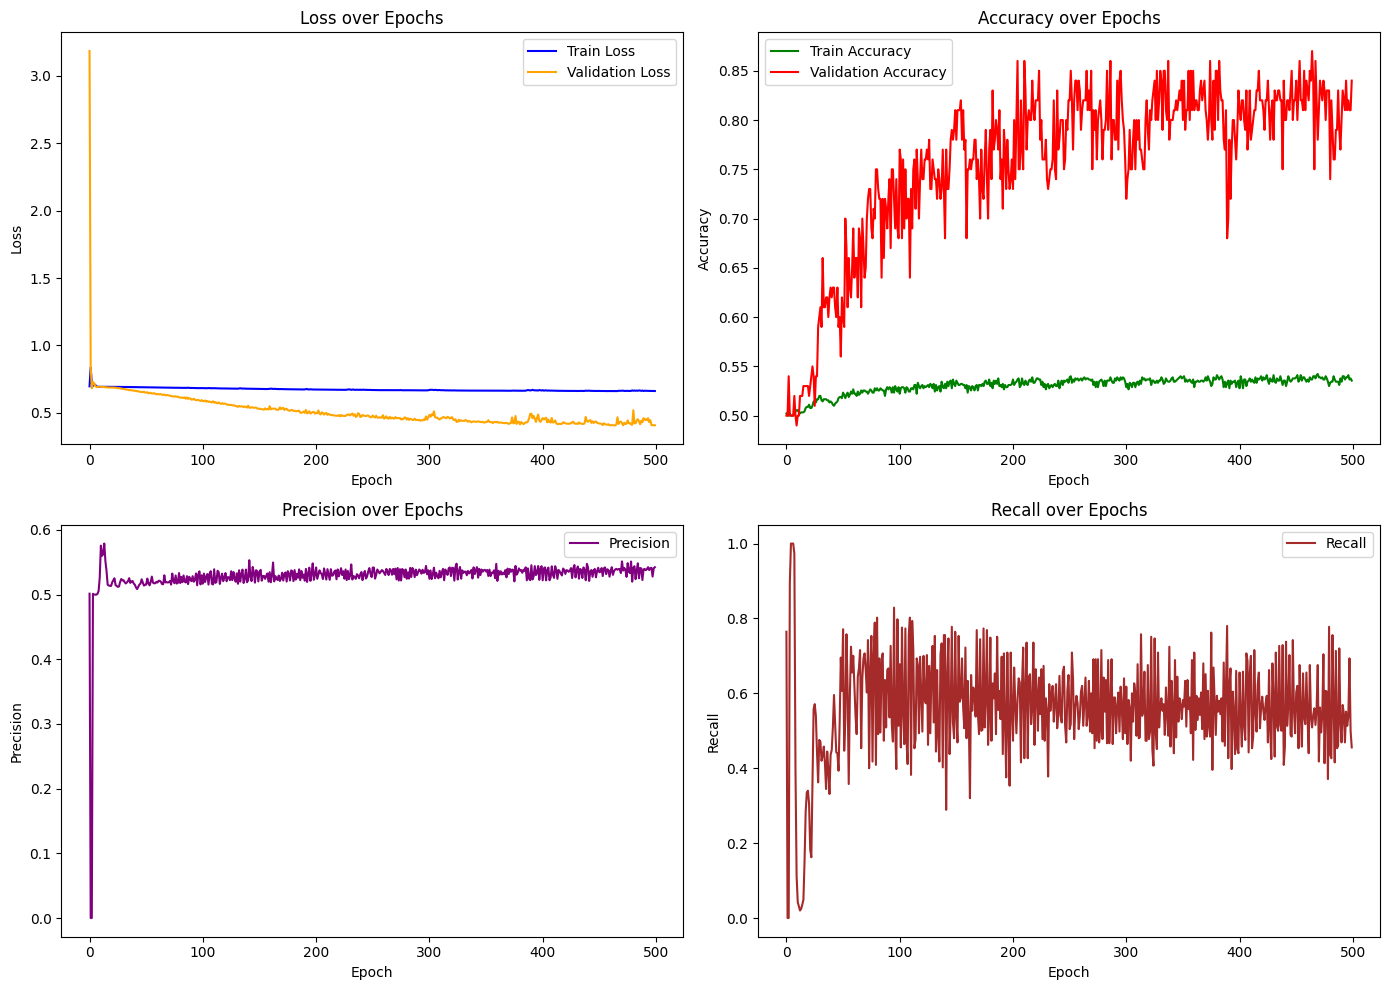

In [29]:
plots_11 = ensemble_yolo11.train(dataloader_test, dataloader_noise_attack, plot=True)

Starting calculation of divergences between non-noisy images
Starting calculating of divergences between noisy images
(500, 84)
Starting model training: 
torch.Size([900, 84])
Epoch 1, Train Loss: 0.6951, Val Loss: 1.1216, Train Accuracy: 0.4978, Val Accuracy: 0.5000, Precision: 0.4988, Recall: 0.9489, F1: 0.6539
Epoch 101, Train Loss: 0.6774, Val Loss: 0.5344, Train Accuracy: 0.5278, Val Accuracy: 0.6900, Precision: 0.5212, Recall: 0.6844, F1: 0.5917
Epoch 201, Train Loss: 0.6687, Val Loss: 0.4704, Train Accuracy: 0.5322, Val Accuracy: 0.7400, Precision: 0.5348, Recall: 0.4956, F1: 0.5144
Epoch 301, Train Loss: 0.6634, Val Loss: 0.4254, Train Accuracy: 0.5389, Val Accuracy: 0.8400, Precision: 0.5341, Recall: 0.6089, F1: 0.5691
Epoch 401, Train Loss: 0.6616, Val Loss: 0.3958, Train Accuracy: 0.5378, Val Accuracy: 0.8200, Precision: 0.5368, Recall: 0.5511, F1: 0.5439
Best model loaded with validation loss: 0.3894


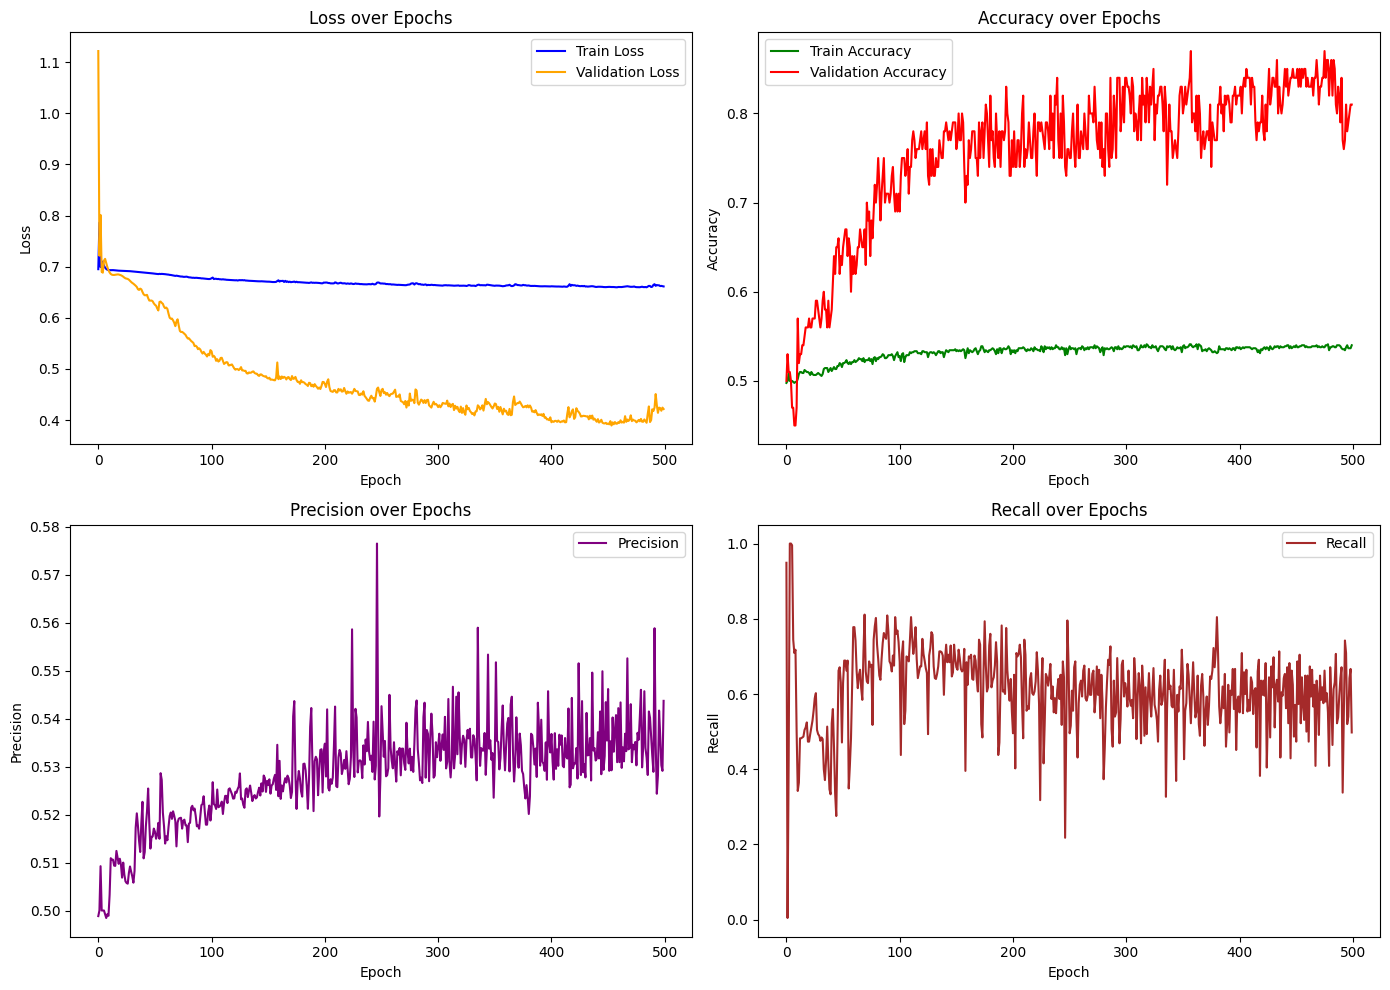

In [32]:
plots_8 = ensemble_yolo8.train(dataloader_test, dataloader_noise_attack, plot=True)

In [33]:
ensemble_yolo11.vote_one_image("/kaggle/input/500-test-images/coco-2017/test/data/000000000016.jpg")


image 1/1 /kaggle/input/500-test-images/coco-2017/test/data/000000000016.jpg: 640x480 2 persons, 1 sports ball, 1 baseball bat, 8.1ms
Speed: 1.2ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


(tensor([True]),
 tensor([0.5323], grad_fn=<RsubBackward1>),
 [ultralytics.engine.results.Results object with attributes:
  
  boxes: ultralytics.engine.results.Boxes object
  keypoints: None
  masks: None
  names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza

In [34]:
ensemble_yolo8.save("ensemble_yolo8")
ensemble_yolo11.save("ensemble_yolo11")

In [37]:
ensemble = EnsembleOfCheckpoints.load("/kaggle/working/ensemble_yolo11.pth")

Loading checkpoint: ./yolo11_checkpoints/epoch60.pt
Loading checkpoint: ./yolo11_checkpoints/epoch65.pt
Loading checkpoint: ./yolo11_checkpoints/epoch70.pt
Loading checkpoint: ./yolo11_checkpoints/epoch75.pt
Loading checkpoint: ./yolo11_checkpoints/epoch80.pt
Loading checkpoint: ./yolo11_checkpoints/epoch85.pt
Loading checkpoint: ./yolo11_checkpoints/epoch90.pt
Loading checkpoint: ./yolo11_checkpoints/epoch95.pt


In [38]:
ensemble.vote_one_image("/kaggle/input/500-test-images/coco-2017/test/data/000000000016.jpg")


image 1/1 /kaggle/input/500-test-images/coco-2017/test/data/000000000016.jpg: 640x480 2 persons, 1 sports ball, 1 baseball bat, 8.9ms
Speed: 1.3ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


(tensor([True]),
 tensor([0.5323], grad_fn=<RsubBackward1>),
 [ultralytics.engine.results.Results object with attributes:
  
  boxes: ultralytics.engine.results.Boxes object
  keypoints: None
  masks: None
  names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza